**Libraries and Imports**

In [5]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import pickle

# Install required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Load the dataset
data = pd.read_csv('/content/amazon_reviews.csv')

# Initialize stopwords and lemmatizer
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Preprocesses the input text by:
    1. Lowercasing
    2. Removing HTML tags, URLs, special characters, and numbers
    3. Tokenizing and removing stopwords
    4. Lemmatizing words

    Args:
        text (str): Input text to preprocess

    Returns:
        str: Preprocessed text
    """
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    tokens = nltk.word_tokenize(text)  # Tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in STOPWORDS]  # Lemmatize and remove stopwords
    return ' '.join(tokens)

# Fill missing reviews with empty strings
data['reviews.text'] = data['reviews.text'].fillna('')

# Apply preprocessing
data['cleaned_reviews'] = data['reviews.text'].apply(preprocess_text)


<ipython-input-6-a0b1bfc34250>:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/amazon_reviews.csv')


In [7]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(data['cleaned_reviews'])

# Dimensionality Reduction
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_svd)


**Load and Preprocess Dataset**

**TF-IDF Feature Extraction**

**Visualize Results**

In [8]:
def safe_silhouette_score(X, labels):
    """
    Returns the silhouette score if there are at least 2 clusters,
    otherwise returns np.nan.
    """
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        return silhouette_score(X, labels)
    return np.nan

def plot_clusters(X_2d, labels, title="Clustering", cmap='viridis'):
    """
    Plots 2D data points colored by cluster labels.
    """
    plt.figure(figsize=(8,6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap=cmap, s=10)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

**Train Models**

=== Selecting best K for K-Means ===
K-Means k=4: silhouette=0.0613
K-Means k=5: silhouette=0.0665
K-Means k=6: silhouette=0.0573
Best K: 5, Silhouette: 0.0665


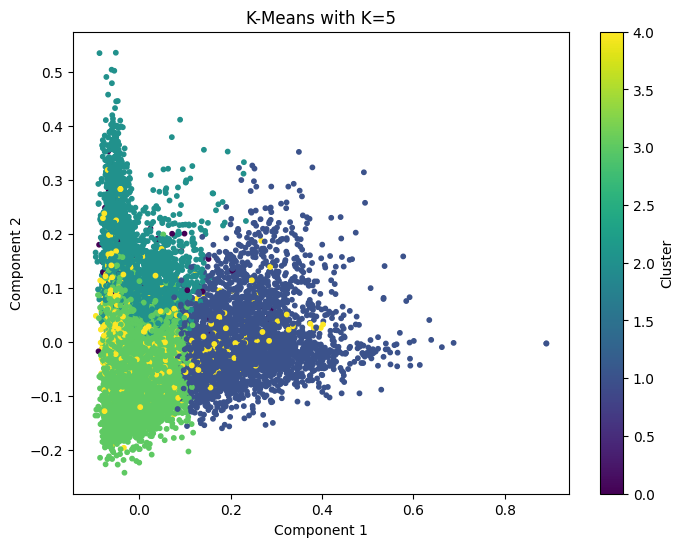

GMM n=4: BIC=-6562536.10, silhouette=-0.0018
GMM n=5: BIC=-6691876.54, silhouette=-0.0153
GMM n=6: BIC=-6777944.09, silhouette=-0.0199


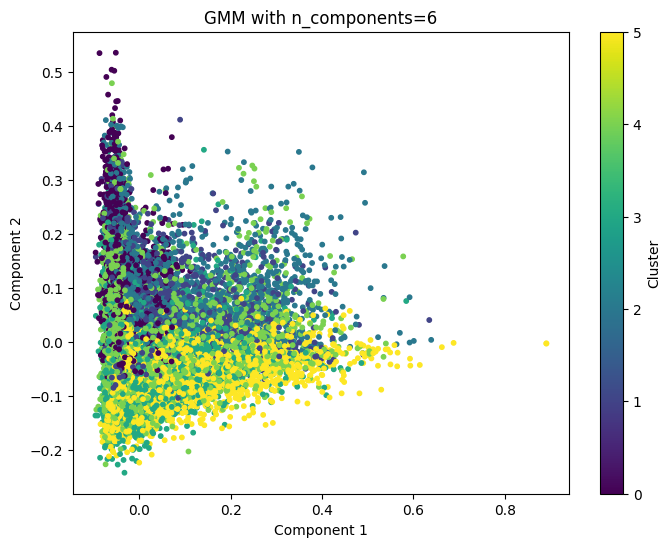

GMM Silhouette Score: -0.0199


In [9]:
# K-Means
def find_best_k_for_kmeans(X, k_range=(4, 6)):
    """
    Tries multiple values of K, returns (best_k, best_score).
    """
    best_k = None
    best_score = -1
    for k in range(k_range[0], k_range[1] + 1):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        score = safe_silhouette_score(X, labels)
        print(f"K-Means k={k}: silhouette={score:.4f}" if not np.isnan(score) else f"K-Means k={k}: single cluster or not applicable")
        if not np.isnan(score) and score > best_score:
            best_score = score
            best_k = k
    return best_k, best_score

print("=== Selecting best K for K-Means ===")
best_k, best_score = find_best_k_for_kmeans(X_svd, k_range=(4, 6))
if best_k is not None:
    print(f"Best K: {best_k}, Silhouette: {best_score:.4f}")
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_svd)
    data['kmeans_cluster'] = kmeans_labels


    plot_clusters(X_2d, kmeans_labels, title=f"K-Means with K={best_k}")

# Gaussian Mixture
def find_best_gmm(X, n_components_range=(4, 6)):
    """
    Tries multiple values of n_components for GMM.
    Returns best model based on the lowest BIC,
    also prints silhouette scores for reference.
    """
    best_gmm = None
    lowest_bic = np.inf
    for n in range(n_components_range[0], n_components_range[1] + 1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(X)
        bic = gmm.bic(X)
        labels = gmm.predict(X)
        sil = safe_silhouette_score(X, labels)
        print(f"GMM n={n}: BIC={bic:.2f}, silhouette={sil:.4f}" if not np.isnan(sil) else f"GMM n={n}: single cluster or not applicable (BIC={bic:.2f})")

        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm
    return best_gmm

    print("\n=== Selecting best n_components for GMM based on BIC ===")
gmm_model = find_best_gmm(X_svd, n_components_range=(4, 6))
if gmm_model is not None:
    gmm_labels = gmm_model.predict(X_svd)
    data['gmm_cluster'] = gmm_labels

    best_n = gmm_model.n_components
    plot_clusters(X_2d, gmm_labels, title=f"GMM with n_components={best_n}")
    gmm_silhouette = silhouette_score(X_svd, gmm_labels)
    print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")


**Identify Clusters**

In [12]:
# Compare Silhouette Scores
if best_k is not None and gmm_model is not None:
    kmeans_silhouette = silhouette_score(X_svd, kmeans_labels)
    gmm_silhouette = silhouette_score(X_svd, gmm_labels)

    print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
    print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")

    # Save the best model
    if kmeans_silhouette > gmm_silhouette:
        best_model = kmeans
        model_name = 'best_kmeans_model.pkl'
        print("K-Means performed better.")
    else:
        best_model = gmm_model
        model_name = 'best_gmm_model.pkl'
        print("GMM performed better.")

    with open(model_name, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Best model saved to {model_name}")


K-Means Silhouette Score: 0.0665
GMM Silhouette Score: -0.0199
K-Means performed better.
Best model saved to best_kmeans_model.pkl


In [13]:
def get_cluster_themes(cluster_labels, vectorizer, X_tfidf, top_n_words=10):
    """
    Identifies the top words for each cluster to derive themes.

    Args:
        cluster_labels (ndarray): Cluster labels for the data points
        vectorizer (TfidfVectorizer): TF-IDF vectorizer used for transformation
        X_tfidf (sparse matrix): TF-IDF representation of the data
        top_n_words (int): Number of top words to extract per cluster

    Returns:
        dict: Dictionary mapping cluster numbers to their top words
    """
    cluster_themes = {}
    for cluster in np.unique(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        cluster_tfidf = X_tfidf[indices]
        cluster_tfidf_sum = cluster_tfidf.sum(axis=0)
        feature_names = vectorizer.get_feature_names_out()
        word_scores = cluster_tfidf_sum.A1
        top_word_indices = np.argsort(word_scores)[::-1][:top_n_words]
        top_words = [feature_names[i] for i in top_word_indices]
        cluster_themes[cluster] = top_words

    return cluster_themes

# Derive themes for clusters
if 'kmeans_cluster' in data.columns:
    kmeans_themes = get_cluster_themes(data['kmeans_cluster'], vectorizer, X_tfidf)
    print("K-Means Cluster Themes:")
    for cluster, words in kmeans_themes.items():
        print(f"Cluster {cluster}: {', '.join(words)}")

if 'gmm_cluster' in data.columns:
    gmm_themes = get_cluster_themes(data['gmm_cluster'], vectorizer, X_tfidf)
    print("\nGMM Cluster Themes:")
    for cluster, words in gmm_themes.items():
        print(f"Cluster {cluster}: {', '.join(words)}")


K-Means Cluster Themes:
Cluster 0: friday, black, black friday, got, price, bought, tablet, bought black, great, got black
Cluster 1: easy, easy use, use, set, easy set, great, love, tablet, love easy, setup
Cluster 2: tablet, great, price, good, year, love, old, kid, year old, great tablet
Cluster 3: love, great, kindle, work, bought, amazon, tv, like, echo, good
Cluster 4: product, great product, great, good product, good, recommend, price, love, product great, amazon

GMM Cluster Themes:
Cluster 0: tablet, great, good, price, kindle, work, reading, kid, love, like
Cluster 1: kindle, tablet, great, book, easy, old, read, love, year, product
Cluster 2: love, bought, tablet, gift, old, year, easy, use, great, christmas
Cluster 3: great, amazon, set, love, got, echo, work, music, tv, bought
Cluster 4: product, great, recommend, work, use, amazon, good, tv, great product, price
Cluster 5: easy, use, love, great, tv, echo, alexa, music, device, amazon


### Based on the themes, these are the most suitable category names for the clusters:

**Cluster 0**: Black Friday Deals - Represents purchases related to Black Friday sales and deals.

**Cluster 1**: Easy to Use - Focuses on products that are easy to set up and use, with positive experiences.

**Cluster 2**: Great for Kids - Highlights products appreciated for their value, often by children or for family use.

**Cluster 3**: Popular Amazon Devices - Includes Amazon-related products like Kindle, Echo, and Fire TV.

**Cluster 4**: Best of the Best - General praise and recommendations for products of good quality and value.

In [17]:
# Map cluster numbers to names
cluster_name_mapping = {
    0: "Black Friday Deals",
    1: "Easy to Use",
    2: "Great for Kids",
    3: "Popular Amazon Devices",
    4: "Best of the Best"
}

# Add a new column with cluster names
data['cluster_name'] = data['kmeans_cluster'].map(cluster_name_mapping)

# Save clustered data
data.to_csv('amazon_reviews_clustered.csv', index=False, encoding='utf-8')
print("amazon_reviews_clustered saved")

amazon_reviews_clustered saved
